In [1]:
import os
import sys

sys.path.append(os.getcwd() + '/../scripts/')

In [2]:
%matplotlib notebook
#from mpl_toolkits.mplot3d import Axes3D # required for 3d plots
import matplotlib.pyplot as plt
#from matplotlib import cm # required for colors

from functools import partial

import numpy as np
np.seterr(all='raise')

from scipy.optimize import minimize

In [3]:
from pymor.core.logger import set_log_levels
set_log_levels({'online_adaptive_lrbms': 'DEBUG',
                'OS2015_academic_problem': 'INFO',
                'local_thermalblock_problem': 'INFO',
                'discretize_elliptic': 'INFO',
                'offline': 'INFO',
                'online_enrichment': 'INFO'})

# setting up the reference discretization

In [4]:
from local_thermalblock_problem import init_grid_and_problem

config = {'num_coarse_grid_elements': [6, 6], 
          'num_grid_refinements': 4,
          'num_grid_subdomains': [6, 6], 
          'num_grid_oversampling_layers': 4, # num_grid_oversampling_layers has to exactly cover one subdomain!
          'enrichment_target_error': -1,
          'marking_doerfler_theta': -1,
          'marking_max_age': -1}

grid_and_problem_data = init_grid_and_problem(config)
#grid_and_problem_data['grid'].visualize('grid', False)

mu_bar = grid_and_problem_data['mu_bar']
parameter_range = grid_and_problem_data['parameter_range']
parameter_range = (parameter_range[0], parameter_range[1])

initial_guess = parameter_range[1] #0.5*(parameter_range[0] + parameter_range[1])

00:01 local_thermalblock_problem: initializing grid and problem ... 


In [5]:
from discretize_elliptic import discretize

block_SWIPDG_disc, block_space, _ = discretize(grid_and_problem_data)
block_SWIPDG_disc.disable_logging()

parameter_space = block_SWIPDG_disc.parameter_space
parameter_type = block_SWIPDG_disc.parameter_type
parse_parameter = block_SWIPDG_disc.parse_parameter
mu_bar = parse_parameter(mu_bar)

00:04 discretize_block_SWIPDG: discretizing ... 


In [6]:
# this is only required to estimate the target error for the online enrichment
print('estimating some detailed errors:')
detailed_errors = []
for mu in np.linspace(parameter_range[0], parameter_range[1], 3):
    mu = parse_parameter(mu)
    print('  {}: '.format(mu), end='', flush=True)
    U = block_SWIPDG_disc.solve(mu)
    estimate = block_SWIPDG_disc.estimate(U, mu=mu)
    print(estimate)
    detailed_errors.append(estimate)

#estimating some detailed errors:
#  {diffusion: [0.0]}: 0.443474715435
#  {diffusion: [1.5707963267948966]}: 0.585792065793
#  {diffusion: [3.141592653589793]}: 0.443474715431

estimating some detailed errors:
  {diffusion: [0.0]}: 0.443474715435
  {diffusion: [1.5707963267948966]}: 0.585792065793
  {diffusion: [3.141592653589793]}: 0.443474715431


In [7]:
# as a result of the above, we set
config['enrichment_target_error'] = 0.65
config['marking_doerfler_theta'] = 0.75
config['marking_max_age'] = 3

# minimizing using the reference discretization

computing some detailed quantities of interest ... done


<IPython.core.display.Javascript object>


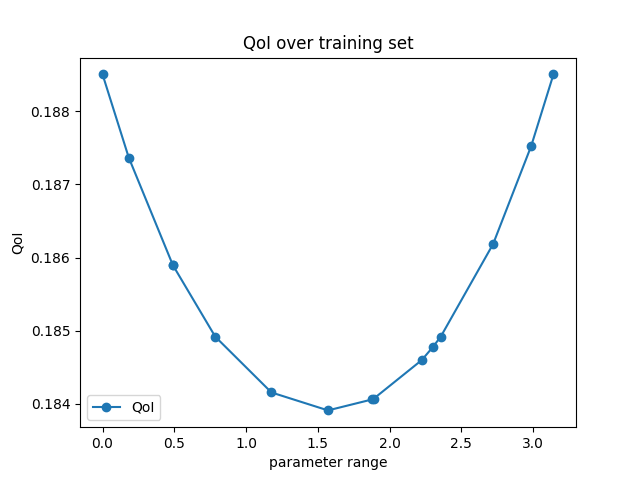

In [8]:
def reference_quantity_of_interest(mu):
    return block_SWIPDG_disc.rhs.apply(block_SWIPDG_disc.solve(mu)).data[0]

print('computing some detailed quantities of interest ... ', end='')

training_set = parameter_space.sample_uniformly(5)
training_set.extend(parameter_space.sample_randomly(10))
training_set = [mu['diffusion'] for mu in training_set]
training_set.sort()
reference_quantities_of_interest = [reference_quantity_of_interest(mu) for mu in training_set]

print('done')

plt.plot(training_set, reference_quantities_of_interest, '-o', label='QoI')
plt.title('QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing reference quantity of interest ........................................ succeded!
  mu_min:    {diffusion: [1.5707973687902426]}
  QoI(mu_min): 0.1839080150053544
  num iterations:     8
  num function calls: 40


<IPython.core.display.Javascript object>


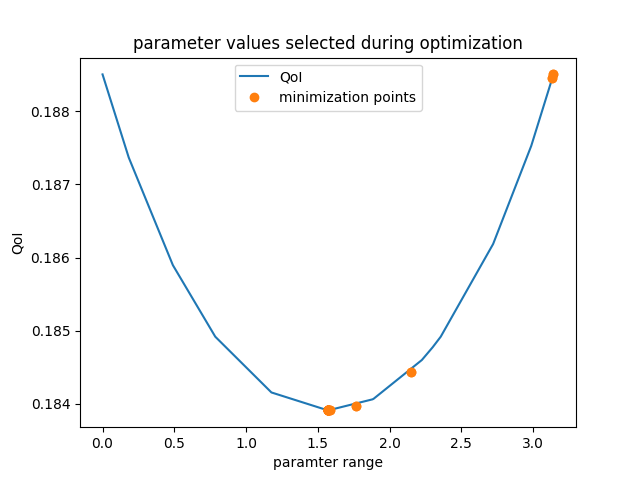

In [9]:
print('minimizing reference quantity of interest ', end='')

reference_minimization_data = {'num_evals': 0,
                               'evaluations' : [],
                               'evaluation_points': []}


def quantity_of_interest(function, data, mu):
    print('.', end='')
    QoI = function(mu)
    data['num_evals'] += 1
    data['evaluation_points'].append(parse_parameter(mu)['diffusion'][0])
    data['evaluations'].append(QoI)
    return QoI


def report(result, data):
    if (result.status != 0):
        print(' failed!')
    else:
        print(' succeded!')
        print('  mu_min:    {}'.format(parse_parameter(result.x)))
        print('  QoI(mu_min): {}'.format(result.fun[0]))
        print('  num iterations:     {}'.format(result.nit))
        print('  num function calls: {}'.format(data['num_evals']))


def extended_report(data):
    for kk, vv in data.items():
        print(kk)
        if isinstance(vv, (list, tuple)):
            for v in vv:
                print('  {}'.format(v))
        else:
            print('  {}'.format(vv))
        print('')


result = minimize(partial(quantity_of_interest, reference_quantity_of_interest, reference_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, reference_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

In [10]:
reference_minimizer = result.x
reference_minimum = result.fun[0]

extended_report(reference_minimization_data)

num_evals
  40

evaluations
  [ 0.18850632]
  [ 0.18850632]
  [ 0.18845975]
  [ 0.18845975]
  [ 0.1844381]
  [ 0.1844381]
  [ 0.18396744]
  [ 0.18396744]
  [ 0.18390824]
  [ 0.18390824]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]

evaluation_points
  3.141592653589793
  3.141592663589793
  3.1347568189137043
  3.134756828913704
  2.1461003810694406
  2.1461003910694405
  1.7654994913708526
  1.7654995013708525
  1.582789323363197
  1.582789333363197
  1.5708040590141965
  1.5708040690141964
  1.570797875578875
  1.570797885578875
  1.5707731418375888
  1.570

# setting up the standard RB discretization

In [11]:
print('reducing with standard RB:', flush=True)

from pymor.algorithms.greedy import greedy
from pymor.discretizations.basic import StationaryDiscretization
from pymor.parameters.functionals import GenericParameterFunctional
from pymor.reductors.coercive import CoerciveRBReductor

from discretize_elliptic import alpha

def coercivity_estimator(mu):
    return 1./np.sqrt(alpha(grid_and_problem_data['lambda']['coefficients'], mu, mu_bar))

SWIPDG_disc = StationaryDiscretization(
    block_SWIPDG_disc.operators['global_op'],
    block_SWIPDG_disc.operators['global_rhs'],
    products={'energy_dg_mu_bar': block_SWIPDG_disc.operators['global_op'].assemble(mu_bar)},
    parameter_space=parameter_space,
    name='SWIPDG')

RB_reductor = CoerciveRBReductor(
    SWIPDG_disc,
    product=SWIPDG_disc.energy_dg_mu_bar_product,
    coercivity_estimator=GenericParameterFunctional(coercivity_estimator, parameter_type))

RB_greedy_data = greedy(SWIPDG_disc, RB_reductor, training_set,
                        extension_params={'method': 'gram_schmidt'},
                        max_extensions=len(training_set))

num_RB_greedy_extensions = RB_greedy_data['extensions']
RB_greedy_mus, RB_greedy_errors = RB_greedy_data['max_err_mus'], RB_greedy_data['max_errs']
RB_greedy_mus = [mu[0] for mu in RB_greedy_mus]

print('RB system is of siez {}x{}'.format(num_RB_greedy_extensions, num_RB_greedy_extensions))
print('maximum estimated model reduction error over training set: {}'.format(RB_greedy_errors[-1]))

reducing with standard RB:


19:20 greedy: Started greedy search on 15 samples
19:20 greedy: Reducing ...
19:20 |   CoerciveRBReductor: RB projection ...
19:20 |   CoerciveRBReductor: Assembling error estimator ...
19:20 |   |   ResidualReductor: Estimating residual range ...
19:20 |   |   |   estimate_image_hierarchical: Estimating image for basis vector -1 ...
19:20 |   |   |   estimate_image_hierarchical: Orthonormalizing ...
19:20 |   |   ResidualReductor: Projecting residual operator ...
19:20 greedy: Estimating errors ...
19:20 greedy: Maximum error after 0 extensions: 0.43417314537470286 (mu = [ 0.])
19:20 greedy: Computing solution snapshot for mu = [ 0.] ...
19:20 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [0.0]} ...
19:20 greedy: Extending basis with solution snapshot ...
      
19:20 greedy: Reducing ...
19:20 |   CoerciveRBReductor: RB projection ...
19:20 |   CoerciveRBReductor: Assembling error estimator ...
19:20 |   |   ResidualReductor: Estimating residual range ...
19:20 |   |  

19:22 |   |   ResidualReductor: Projecting residual operator ...
19:22 greedy: Estimating errors ...
19:22 greedy: Maximum error after 9 extensions: 9.459853577765518e-12 (mu = [ 3.14159265])
19:22 greedy: Computing solution snapshot for mu = [ 3.14159265] ...
19:22 |   StationaryDiscretization: Solving SWIPDG for {diffusion: [3.141592653589793]} ...
19:22 greedy: Extending basis with solution snapshot ...
19:22 |   gram_schmidt: Removing linear dependent vector 9
19:22 |   greedy: Extension failed. Stopping now.
19:22 greedy: Greedy search took 1.8953001499176025 seconds


RB system is of siez 9x9
maximum estimated model reduction error over training set: 9.459853577765518e-12


<IPython.core.display.Javascript object>


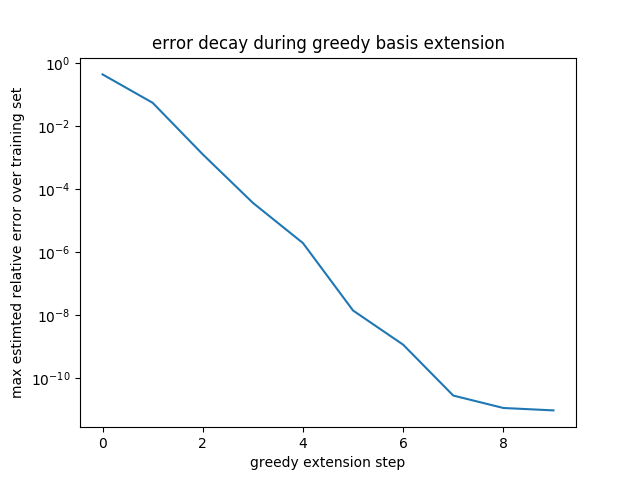

In [12]:
RB_rd = RB_greedy_data['reduced_discretization']
RB_rd.disable_logging()

plt.plot(list(range(num_RB_greedy_extensions)) + [len(range(num_RB_greedy_extensions))],
         RB_greedy_errors)
plt.yscale('log')
plt.title('error decay during greedy basis extension')
plt.xlabel('greedy extension step')
plt.ylabel('max estimted relative error over training set')

# minimizing using the standard RB discretization

<IPython.core.display.Javascript object>


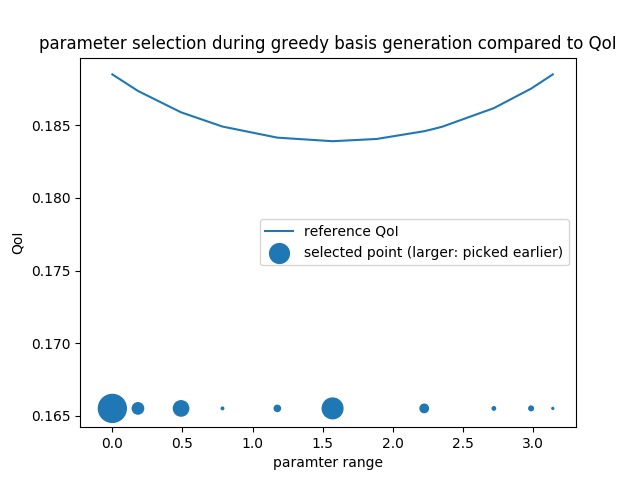

In [13]:
def RB_quantity_of_interest(mu):
    return RB_rd.rhs.apply(RB_rd.solve(mu)).data[0]

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.scatter(RB_greedy_mus,
            [0.9*np.min(reference_quantities_of_interest) for mu in RB_greedy_mus],
            s=np.exp(6.*np.linspace(1, 0.1, len(RB_greedy_mus))),
            label='selected point (larger: picked earlier)')
plt.title('parameter selection during greedy basis generation compared to QoI')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

computing some RB quantities of interest ... done
L-infty error of QoI over training set: 2.0426993430078255e-12


<IPython.core.display.Javascript object>


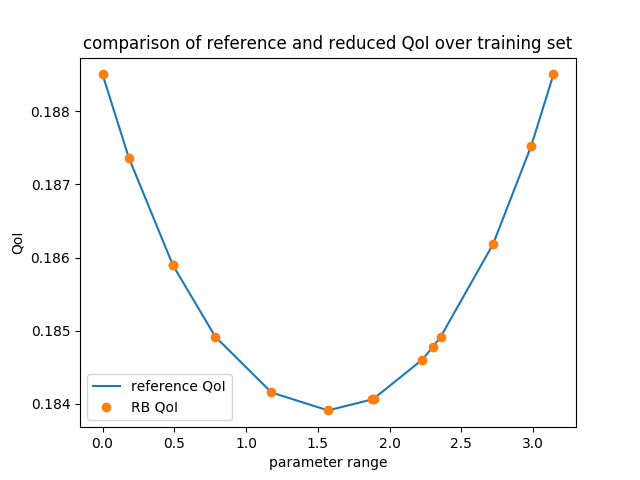

In [14]:
print('computing some RB quantities of interest ... ', end='')
RB_quantities_of_interest = [RB_quantity_of_interest(mu) for mu in training_set]
print('done')

print('L-infty error of QoI over training set: {}'.format(
    np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(RB_quantities_of_interest)))
))

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(training_set, RB_quantities_of_interest, 'o', label='RB QoI')
plt.title('comparison of reference and reduced QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing reduced quantity of interest ........................ succeded!
  mu_min:    {diffusion: [1.5707964268546328]}
  QoI(mu_min): 0.183908015005309
  num iterations:     8
  num function calls: 24


<IPython.core.display.Javascript object>


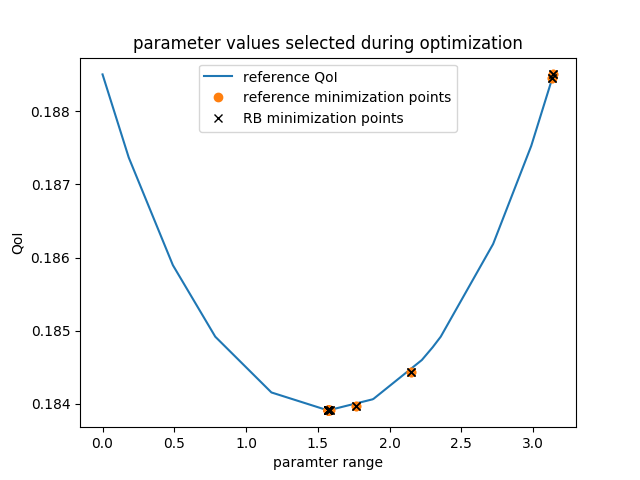

In [15]:
print('minimizing reduced quantity of interest ', end='')

RB_minimization_data = {'num_evals': 0,
                        'evaluations' : [],
                        'evaluation_points': []}

result = minimize(partial(quantity_of_interest, RB_quantity_of_interest, RB_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, RB_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
plt.plot(RB_minimization_data['evaluation_points'],
         [RB_quantity_of_interest(mu) for mu in RB_minimization_data['evaluation_points']],
         'kx', label='RB minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

In [16]:
RB_minimizer = result.x
RB_minimum = result.fun

print('relative RB minimizer error: {}'.format(
    (np.abs(reference_minimizer - RB_minimizer)/np.abs(reference_minimizer))[0]))
print('relative RB minimum error:   {}'.format(
    (np.abs(reference_minimum - RB_minimum)/np.abs(reference_minimum))[0]))
print('')

extended_report(RB_minimization_data)

relative RB minimizer error: 5.996544356693929e-07
relative RB minimum error:   2.4675578239606383e-13

num_evals
  24

evaluations
  [ 0.18850632]
  [ 0.18850632]
  [ 0.18845975]
  [ 0.18845975]
  [ 0.18443844]
  [ 0.18443844]
  [ 0.18396745]
  [ 0.18396745]
  [ 0.18390824]
  [ 0.18390824]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]
  [ 0.18390802]

evaluation_points
  3.141592653589793
  3.141592663589793
  3.134756827240377
  3.134756837240377
  2.1462793637357547
  2.1462793737357546
  1.7655041835659675
  1.7655041935659674
  1.5827890596470755
  1.5827890696470754
  1.5708657960280337
  1.5708658060280336
  1.570797455154231
  1.570797465154231
  1.5707956327309296
  1.5707956427309295
  1.5707962402053635
  1.5707962502053634
  1.570798670103099
  1.5707986801030989
  1.5707967003009093
  1.5707967103009093
  1.570796

# setting up the LRBMS discretization

In [ ]:
# Choice, part 1/2: either we use the offline/online decomposable estimator ...
LRBMS_disc = block_SWIPDG_disc

In [17]:
# ... or we use the high-dimensional estimator
LRBMS_disc = block_SWIPDG_disc.with_(operators={name: op
                                                for name, op in block_SWIPDG_disc.operators.items() if (
                                                    name != 'operator'
                                                    and name != 'rhs'
                                                    and name[:3] != 'nc_'
                                                    and name[:1] != 'r'
                                                    and name[:3] != 'df_'
                                                    and name[:7] != 'global_')})

In [18]:
#from pymor.core.exceptions import ExtensionError

from offline import init_local_reduced_bases

LRBMS_0_reductor = init_local_reduced_bases(grid_and_problem_data['grid'],
                                            LRBMS_disc,
                                            block_space,
                                            0)

#print('adding some global solution snapshots to reduced basis ...', flush=True)
#for mu in parameter_range:
#    U = block_SWIPDG_disc.solve(mu)
#    try:
#        LRBMS_reductor.extend_basis(U)
#    except ExtensionError:
#        pass
#print('')

20:18 init_local_reduced_bases: initializing local reduced bases with DG shape functions of up to order 0 ... 


In [ ]:
# Choice, part 2/2: either we use the offline/online decomposable estimator ...
estimator = None

In [19]:
# ... or we use the high-dimensional estimator
class FakeEstimator(object):

    def __init__(self, disc, reductor):
        self.disc = disc
        self.reductor = reductor

    def estimate(self, U, mu, discretization, decompose=False):
        return self.disc.estimate(self.reductor.reconstruct(U), mu=mu, decompose=decompose)

LRBMS_0_estimator = FakeEstimator(block_SWIPDG_disc, LRBMS_0_reductor)

In [20]:
print('reducing:')
LRBMS_0_rd = LRBMS_0_reductor.reduce()
LRBMS_0_rd = LRBMS_0_rd.with_(estimator=LRBMS_0_estimator)
LRBMS_0_rd.disable_logging()
print('initial reduced (LRBMS) system is of size {}x{}'.format(LRBMS_0_rd.solution_space.dim,
                                                               LRBMS_0_rd.solution_space.dim))

20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_0: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_1: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_2: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_3: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_4: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_5: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_energy_dg_product_6: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
20:25 GenericRBSystemReductor: Projecting local_

reducing:
initial reduced (LRBMS) system is of size 36x36


# minimizing using the LRBMS discretization

## using the (insufficient) initial zero-order basis

computing some zero order LRBMS reduced quantities of interest ...
L-infty error w.r.t. reference QoI: 0.17873886321167817


<IPython.core.display.Javascript object>


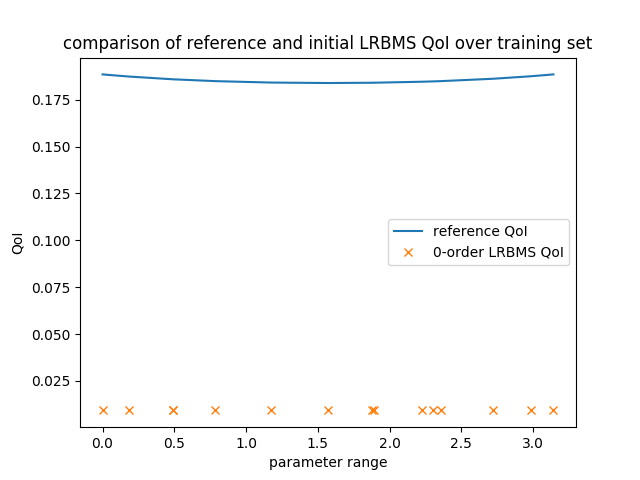

In [21]:
def LRBMS_0_quantity_of_interest(mu):
    return LRBMS_0_rd.rhs.apply(LRBMS_0_rd.solve(mu)).data[0]

print('computing some zero order LRBMS reduced quantities of interest ...')

LRBMS_0_quantities_of_interest = [LRBMS_0_quantity_of_interest(mu) for mu in training_set]

print('L-infty error w.r.t. reference QoI: {}'.format(
    np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(LRBMS_0_quantities_of_interest)))
))

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(training_set, LRBMS_0_quantities_of_interest, 'x', label='0-order LRBMS QoI')
plt.title('comparison of reference and initial LRBMS QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing order-0 LRBMS quantity of interest .................... succeded!
  mu_min:    {diffusion: [1.570796227987911]}
  QoI(mu_min): 0.009311924005612376
  num iterations:     6
  num function calls: 20

relative LRBMS (order-1) minimizer error: 7.262568388233324e-07
relative LRBMS (order-1) QoI error:   0.9493664046923607

num_evals
  20

evaluations
  [ 0.00976746]
  [ 0.00976746]
  [ 0.00976715]
  [ 0.00976715]
  [ 0.00939004]
  [ 0.00939004]
  [ 0.00931211]
  [ 0.00931211]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]
  [ 0.00931192]

evaluation_points
  3.141592653589793
  3.141592663589793
  3.1410394010071574
  3.1410394110071573
  0.927691010229081
  0.927691020229081
  1.6023681633634732
  1.6023681733634731
  1.5707135093997953
  1.5707135193997952
  1.5707960807745285
  1.5707960907745284
  1.5707965420671248
  1.5707965520671248
  1.57079623

<IPython.core.display.Javascript object>


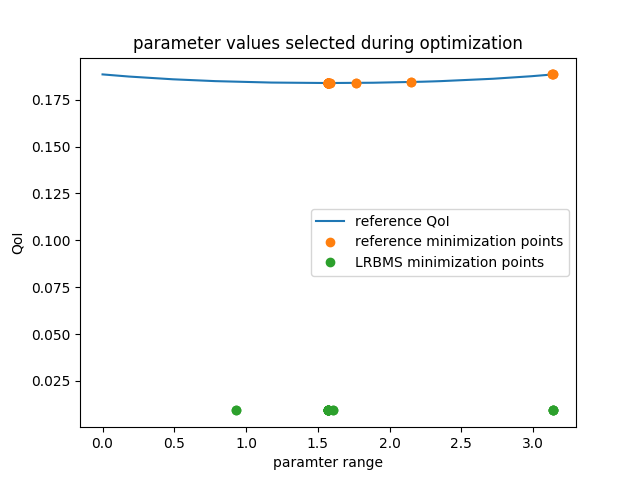

In [22]:
print('minimizing order-0 LRBMS quantity of interest ', end='')

LRBMS_0_minimization_data = {'num_evals': 0,
                             'evaluations' : [],
                             'evaluation_points': []}

result = minimize(partial(quantity_of_interest, LRBMS_0_quantity_of_interest, LRBMS_0_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, LRBMS_0_minimization_data)

LRBMS_0_minimizer = result.x
LRBMS_0_minimum = result.fun

print('')
print('relative LRBMS (order-0) minimizer error: {}'.format(
    (np.abs(reference_minimizer - LRBMS_0_minimizer)/np.abs(reference_minimizer))[0]))
print('relative LRBMS (order-0) QoI error:   {}'.format(
    (np.abs(reference_minimum - LRBMS_0_minimum)/np.abs(reference_minimum))[0]))
print('')

extended_report(LRBMS_0_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
#plt.plot(RB_minimization_data['evaluation_points'],
#         [RB_quantity_of_interest(mu) for mu in RB_minimization_data['evaluation_points']],
#         'kx', label='RB minimization points')
plt.plot(LRBMS_0_minimization_data['evaluation_points'],
         [LRBMS_0_quantity_of_interest(mu) for mu in LRBMS_0_minimization_data['evaluation_points']],
         'o', label='LRBMS minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

## order 1 basis

In [23]:
LRBMS_reductor = init_local_reduced_bases(grid_and_problem_data['grid'],
                                          LRBMS_disc,
                                          block_space,
                                          1)
LRBMS_estimator = FakeEstimator(block_SWIPDG_disc, LRBMS_reductor)
LRBMS_disc.with_(estimator=LRBMS_estimator)

print('reducing:')
LRBMS_rd = LRBMS_reductor.reduce()
LRBMS_rd = LRBMS_rd.with_(estimator=LRBMS_estimator)
LRBMS_rd.disable_logging()
print('initial first order LRBMS system is of size {}x{}'.format(LRBMS_rd.solution_space.dim,
                                                                 LRBMS_rd.solution_space.dim))

21:06 init_local_reduced_bases: initializing local reduced bases with DG shape functions of up to order 1 ... 
21:06 gram_schmidt: Orthonormalizing vector 3 again
21:06 gram_schmidt: Orthonormalizing vector 3 again
21:06 gram_schmidt: Orthonormalizing vector 1 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 1 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 1 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 1 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07 gram_schmidt: Orthonormalizing vector 3 again
21:07

reducing:


initial first order LRBMS system is of size 144x144


computing some first order LRBMS reduced quantities of interest ...
L-infty error w.r.t. reference QoI: 0.008186582404702991


<IPython.core.display.Javascript object>


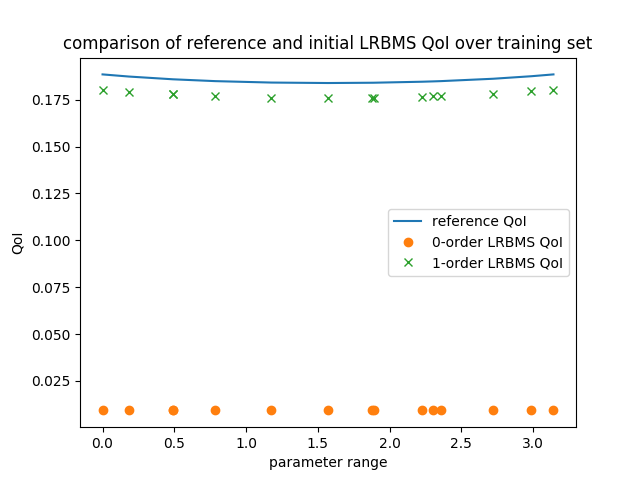

In [24]:
def LRBMS_quantity_of_interest(mu):
    return LRBMS_rd.rhs.apply(LRBMS_rd.solve(mu)).data[0]

print('computing some first order LRBMS reduced quantities of interest ...')

LRBMS_quantities_of_interest = [LRBMS_quantity_of_interest(mu) for mu in training_set]

print('L-infty error w.r.t. reference QoI: {}'.format(
    np.max(np.abs(np.array(reference_quantities_of_interest) - np.array(LRBMS_quantities_of_interest)))
))

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(training_set, LRBMS_0_quantities_of_interest, 'o', label='0-order LRBMS QoI')
plt.plot(training_set, LRBMS_quantities_of_interest, 'x', label='1-order LRBMS QoI')
plt.title('comparison of reference and initial LRBMS QoI over training set')
plt.xlabel('parameter range')
plt.ylabel('QoI')
plt.legend()

minimizing order-1 LRBMS quantity of interest .............................................................................................. succeded!
  mu_min:    {diffusion: [1.5707943717082564]}
  QoI(mu_min): 0.1758675097770865
  num iterations:     8
  num function calls: 94

relative LRBMS (order-1) minimizer error: 1.908000386105113e-06
relative LRBMS (order-1) QoI error:   0.04372025454156408

num_evals
  94

evaluations
  [ 0.18031974]
  [ 0.18031974]
  [ 0.18028182]
  [ 0.18028182]
  [ 0.17599539]
  [ 0.17599539]
  [ 0.17587264]
  [ 0.17587264]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.17586751]
  [ 0.1

<IPython.core.display.Javascript object>


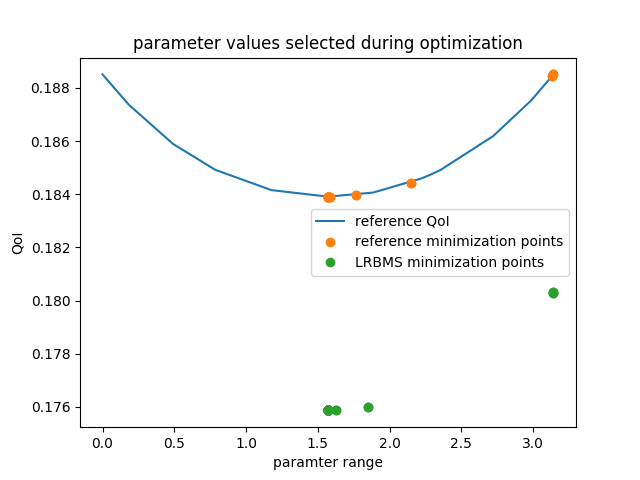

In [25]:
print('minimizing order-1 LRBMS quantity of interest ', end='')

LRBMS_minimization_data = {'num_evals': 0,
                           'evaluations' : [],
                           'evaluation_points': []}

result = minimize(partial(quantity_of_interest, LRBMS_quantity_of_interest, LRBMS_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, LRBMS_minimization_data)

LRBMS_minimizer = result.x
LRBMS_minimum = result.fun

print('')
print('relative LRBMS (order-1) minimizer error: {}'.format(
    (np.abs(reference_minimizer - LRBMS_minimizer)/np.abs(reference_minimizer))[0]))
print('relative LRBMS (order-1) QoI error:   {}'.format(
    (np.abs(reference_minimum - LRBMS_minimum)/np.abs(reference_minimum))[0]))
print('')

extended_report(LRBMS_minimization_data)

plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
#plt.plot(RB_minimization_data['evaluation_points'],
#         [RB_quantity_of_interest(mu) for mu in RB_minimization_data['evaluation_points']],
#         'kx', label='RB minimization points')
plt.plot(LRBMS_minimization_data['evaluation_points'],
         [LRBMS_quantity_of_interest(mu) for mu in LRBMS_minimization_data['evaluation_points']],
         'o', label='LRBMS minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

## using the adaptive online enrichment

<IPython.core.display.Javascript object>


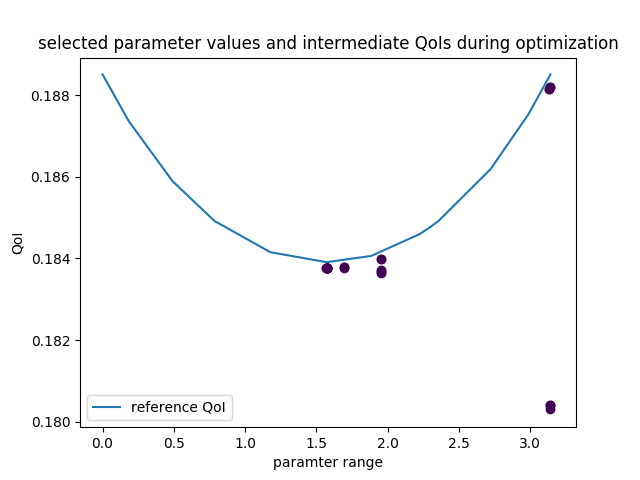

In [26]:
# This cell is only here to have the interactive plot in a good view
plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.title('selected parameter values and intermediate QoIs during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

In [27]:
print('minimizing adaptive LRBMS quantity of interest ', end='')

from online_enrichment import AdaptiveEnrichment

online_adaptive_LRBMS = AdaptiveEnrichment(grid_and_problem_data,
                                           LRBMS_disc, block_space,
                                           LRBMS_reductor, LRBMS_rd,
                                           config['enrichment_target_error'],
                                           config['marking_doerfler_theta'],
                                           config['marking_max_age'],
                                           fake_estimator=LRBMS_estimator)
#online_adaptive_LRBMS.disable_logging()
#for ii in ('online_enrichment',
#           'pymor.algorithms.gram_schmidt',
#           'pymor.reductors.system'):
#    set_log_levels({ii: 'WARN'})

adaptive_LRBMS_minimization_data = {'num_evals': 0,
                                    'evaluation_points': [],
                                    'evaluations' : [],
                                    'intermediate_evaluations' : [],
                                    'intermediate_evaluation_points': [],
                                    'num_local_solves': []}


def adaptive_LRBMS_quantity_of_interest(mu):
    
    num_solves = [0]
    
    def callback(rd_, U_, mu_, data_):
        adaptive_LRBMS_minimization_data['intermediate_evaluation_points'].append(mu_['diffusion'][0])
        QoI = rd_.rhs.apply(U_).data[0]
        adaptive_LRBMS_minimization_data['intermediate_evaluations'].append(QoI)
        num_solves[0] += data_['local_problem_solves']
        plt.scatter([mu_['diffusion'][0], ], [QoI, ], c=[mu_['diffusion'][0], ])


    mu = parse_parameter(mu)
    U, rd, _ = online_adaptive_LRBMS.solve(mu, callback=callback)
    
    adaptive_LRBMS_minimization_data['num_local_solves'].append(num_solves[0])
    
    return rd.rhs.apply(U).data[0]


result = minimize(partial(quantity_of_interest,
                          adaptive_LRBMS_quantity_of_interest,
                          adaptive_LRBMS_minimization_data),
                  initial_guess,
                  method='L-BFGS-B', jac=False,
                  bounds=(parameter_range,),
                  options={'ftol': 1e-15, 'gtol': 1e-15})

report(result, adaptive_LRBMS_minimization_data)

22:05 AdaptiveEnrichment: solving 144-dimensional system for mu = {diffusion: [3.141592653589793]} ...


minimizing adaptive LRBMS quantity of interest .

24:59 |   |INFO3|AdaptiveEnrichment: estimated error 0.7173396591241099 above target error of 0.65, enriching ...
24:59 |   |INFO3|AdaptiveEnrichment: marked 5/36 subdomains due to Dörfler marking
24:59 |   |INFO3|AdaptiveEnrichment:    and 0/31 additionally due to age marking
24:59 |   |INFO3|AdaptiveEnrichment: solving local corrector problems on 5 subdomains ...
24:59 |   GenericRBSystemReductor: Projecting local_energy_dg_product_0: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
24:59 |   GenericRBSystemReductor: Projecting local_energy_dg_product_1: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
24:59 |   GenericRBSystemReductor: Projecting local_energy_dg_product_2: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
24:59 |   GenericRBSystemReductor: Projecting local_energy_dg_product_3: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
24:59 |   GenericRBSystemReductor: Projecting local_energy_dg_product_4:

28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_13: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_14: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_7: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_16: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_17: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_18: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   GenericRBSystemReductor: Projecting local_energy_dg_product_19: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
28:01 |   Gene

31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_29: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_30: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_31: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_32: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_33: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_34: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   GenericRBSystemReductor: Projecting local_energy_dg_product_35: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
31:09 |   Gen

.

40:01 |   |INFO3|AdaptiveEnrichment: estimated error 0.5332476329280882 below target error of 0.65, no enrichment required ...
40:01 AdaptiveEnrichment: solving 195-dimensional system for mu = {diffusion: [3.1347952936926227]} ...


.

42:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.5344602707647328 below target error of 0.65, no enrichment required ...
42:54 AdaptiveEnrichment: solving 195-dimensional system for mu = {diffusion: [3.1347953036926226]} ...


.

45:56 |   |INFO3|AdaptiveEnrichment: estimated error 0.5344602689733187 below target error of 0.65, no enrichment required ...
45:56 AdaptiveEnrichment: solving 195-dimensional system for mu = {diffusion: [1.9527066394711161]} ...


.

48:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.7038883223364435 above target error of 0.65, enriching ...
48:54 |   |INFO3|AdaptiveEnrichment: marked 5/36 subdomains due to Dörfler marking
48:54 |   |INFO3|AdaptiveEnrichment:    and 0/31 additionally due to age marking
48:54 |   |INFO3|AdaptiveEnrichment: solving local corrector problems on 5 subdomains ...
48:54 |   gram_schmidt: Orthonormalizing vector 8 again
48:54 |   gram_schmidt: Orthonormalizing vector 8 again
48:54 |   gram_schmidt: Orthonormalizing vector 8 again
48:54 |   gram_schmidt: Orthonormalizing vector 8 again
48:54 |   gram_schmidt: Orthonormalizing vector 8 again
48:54 |   GenericRBSystemReductor: Projecting local_energy_dg_product_0: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
48:54 |   GenericRBSystemReductor: Projecting local_energy_dg_product_2: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
48:54 |   GenericRBSystemReductor: Projecting local_energy_dg_product_1:

51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_11: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_12: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_13: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_14: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_15: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_16: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   GenericRBSystemReductor: Projecting local_energy_dg_product_17: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
51:52 |   Gen

54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_26: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_27: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_28: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_29: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_30: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_31: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   GenericRBSystemReductor: Projecting local_energy_dg_product_32: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
54:40 |   Gen

57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_29: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_30: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_31: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_32: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_33: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_34: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   GenericRBSystemReductor: Projecting local_energy_dg_product_35: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
57:26 |   Gen

.

01:03:00 |   |INFO3|AdaptiveEnrichment: estimated error 0.6423377932682888 below target error of 0.65, no enrichment required ...
01:03:00 AdaptiveEnrichment: solving 246-dimensional system for mu = {diffusion: [1.6906894420607546]} ...


.

01:05:46 |   |INFO3|AdaptiveEnrichment: estimated error 0.6508171778944412 above target error of 0.65, enriching ...
01:05:46 |   |INFO3|AdaptiveEnrichment: marked 5/36 subdomains due to Dörfler marking
01:05:46 |   |INFO3|AdaptiveEnrichment:    and 0/31 additionally due to age marking
01:05:46 |   |INFO3|AdaptiveEnrichment: solving local corrector problems on 5 subdomains ...
01:05:46 |   gram_schmidt: Orthonormalizing vector 12 again
01:05:46 |   gram_schmidt: Orthonormalizing vector 12 again
01:05:46 |   gram_schmidt: Orthonormalizing vector 12 again
01:05:46 |   gram_schmidt: Orthonormalizing vector 12 again
01:05:46 |   gram_schmidt: Orthonormalizing vector 12 again
01:05:46 |   GenericRBSystemReductor: Projecting local_energy_dg_product_0: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
01:05:46 |   GenericRBSystemReductor: Projecting local_energy_dg_product_1: R^96 --> R^96  (parameter type: None, class: DuneXTMatrixOperator)
01:05:46 |   GenericRBSystemReduct

.

01:11:18 |   |INFO3|AdaptiveEnrichment: estimated error 0.6445027753559726 below target error of 0.65, no enrichment required ...
01:11:18 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.573978566402422]} ...


.

01:14:04 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454313535019323 below target error of 0.65, no enrichment required ...
01:14:04 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.573978576402422]} ...


.

01:16:50 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454313534984838 below target error of 0.65, no enrichment required ...
01:16:50 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5707897302262266]} ...


.

01:19:36 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084777814 below target error of 0.65, no enrichment required ...
01:19:36 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5707897402262265]} ...


.

01:22:22 |   |INFO3|AdaptiveEnrichment: estimated error 0.645432008477542 below target error of 0.65, no enrichment required ...
01:22:22 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.570840855588834]} ...


.

01:25:08 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320083525015 below target error of 0.65, no enrichment required ...
01:25:08 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.570840865588834]} ...


.

01:27:54 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320083521323 below target error of 0.65, no enrichment required ...
01:27:54 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708008383493446]} ...


.

01:30:56 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084790532 below target error of 0.65, no enrichment required ...
01:30:56 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708008483493445]} ...


.

01:33:57 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084792469 below target error of 0.65, no enrichment required ...
01:33:57 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708057150863233]} ...


.

01:43:30 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084729934 below target error of 0.65, no enrichment required ...
01:43:30 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708057250863232]} ...


.

01:46:27 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084742673 below target error of 0.65, no enrichment required ...
01:46:27 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708022988837356]} ...


.

01:49:33 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084780722 below target error of 0.65, no enrichment required ...
01:49:33 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708023088837355]} ...


.

01:52:23 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084770822 below target error of 0.65, no enrichment required ...
01:52:23 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708014084822757]} ...


.

01:55:14 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084781635 below target error of 0.65, no enrichment required ...
01:55:14 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708014184822756]} ...


.

01:58:17 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084776712 below target error of 0.65, no enrichment required ...
01:58:17 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708010755090793]} ...


.

02:01:02 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084782871 below target error of 0.65, no enrichment required ...
02:01:02 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708010855090793]} ...


.

02:03:53 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084781477 below target error of 0.65, no enrichment required ...
02:03:53 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708008816539538]} ...


.

02:06:41 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084791817 below target error of 0.65, no enrichment required ...
02:06:41 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.5708008916539538]} ...


.

02:09:32 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084787555 below target error of 0.65, no enrichment required ...
02:09:32 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.570800846440691]} ...


.

02:12:21 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084780858 below target error of 0.65, no enrichment required ...
02:12:21 AdaptiveEnrichment: solving 251-dimensional system for mu = {diffusion: [1.570800856440691]} ...


.

02:15:07 |   |INFO3|AdaptiveEnrichment: estimated error 0.6454320084780095 below target error of 0.65, no enrichment required ...


 succeded!
  mu_min:    {diffusion: [1.570800846440691]}
  QoI(mu_min): 0.18377071141303733
  num iterations:     7
  num function calls: 28


In [28]:
adaptive_LRBMS_minimizer = result.x
adaptive_LRBMS_minimum = result.fun

print('')
print('relative LRBMS (adaptive) minimizer error: {}'.format(
    (np.abs(reference_minimizer - adaptive_LRBMS_minimizer)/np.abs(reference_minimizer))[0]))
print('relative LRBMS (adaptive) QoI error:   {}'.format(
    (np.abs(reference_minimum - adaptive_LRBMS_minimum)/np.abs(reference_minimum))[0]))
print('')

extended_report(adaptive_LRBMS_minimization_data)


relative LRBMS (adaptive) minimizer error: 2.2139395682720522e-06
relative LRBMS (adaptive) QoI error:   0.0007465884089557721

num_evals
  28

evaluation_points
  3.141592653589793
  3.141592663589793
  3.1347952936926227
  3.1347953036926226
  1.9527066394711161
  1.952706649471116
  1.6906894420607546
  1.6906894520607545
  1.573978566402422
  1.573978576402422
  1.5707897302262266
  1.5707897402262265
  1.570840855588834
  1.570840865588834
  1.5708008383493446
  1.5708008483493445
  1.5708057150863233
  1.5708057250863232
  1.5708022988837356
  1.5708023088837355
  1.5708014084822757
  1.5708014184822756
  1.5708010755090793
  1.5708010855090793
  1.5708008816539538
  1.5708008916539538
  1.570800846440691
  1.570800856440691

evaluations
  [ 0.18820683]
  [ 0.18820683]
  [ 0.18816076]
  [ 0.18816076]
  [ 0.18398115]
  [ 0.18398115]
  [ 0.18379334]
  [ 0.18379334]
  [ 0.18377073]
  [ 0.18377073]
  [ 0.18377071]
  [ 0.18377071]
  [ 0.18377071]
  [ 0.18377071]
  [ 0.18377071]
  [ 0

In [29]:
for s, b in online_adaptive_LRBMS.reductor.bases.items():
    print('{}: {}'.format(s, len(b)))

domain_0: 6
domain_1: 6
domain_2: 6
domain_3: 6
domain_4: 6
domain_5: 6
domain_6: 6
domain_7: 6
domain_8: 6
domain_9: 6
domain_10: 6
domain_11: 6
domain_12: 6
domain_13: 6
domain_14: 6
domain_15: 6
domain_16: 6
domain_17: 6
domain_18: 6
domain_19: 6
domain_20: 6
domain_21: 6
domain_22: 6
domain_23: 6
domain_24: 6
domain_25: 13
domain_26: 13
domain_27: 13
domain_28: 6
domain_29: 6
domain_30: 6
domain_31: 6
domain_32: 13
domain_33: 13
domain_34: 6
domain_35: 6


<IPython.core.display.Javascript object>


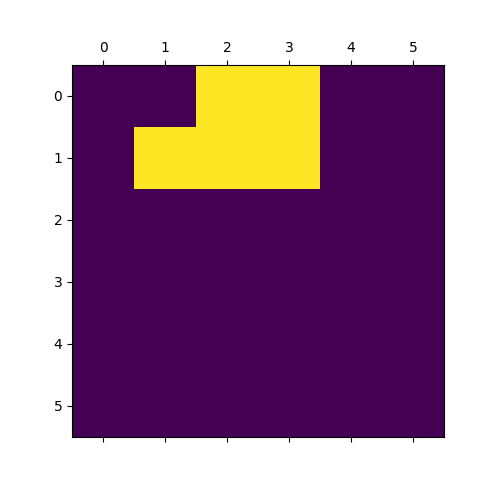

In [66]:
basis_sizes = 6.0*np.ones((6, 6))
basis_sizes[1][1] = 13
basis_sizes[1][2] = 13
basis_sizes[1][3] = 13
basis_sizes[0][2] = 13
basis_sizes[0][3] = 13
basis_sizes
plt.matshow(basis_sizes)

In [ ]:
plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.plot(reference_minimization_data['evaluation_points'],
         [reference_quantity_of_interest(mu) for mu in reference_minimization_data['evaluation_points']],
         'o', label='reference minimization points')
plt.plot(adaptive_LRBMS_minimization_data['evaluation_points'],
         [adaptive_LRBMS_quantity_of_interest(mu) for mu in adaptive_LRBMS_minimization_data['evaluation_points']],
         'kx', label='adaptive LRBMS minimization points')
plt.title('parameter values selected during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()

<IPython.core.display.Javascript object>


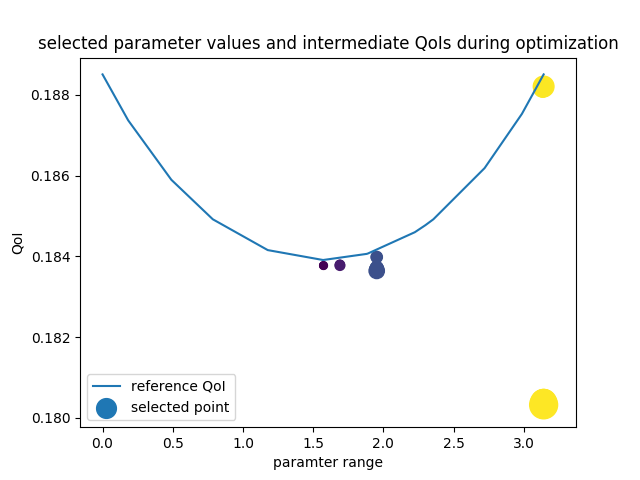

In [67]:
plt.plot(training_set, reference_quantities_of_interest, label='reference QoI')
plt.scatter(adaptive_LRBMS_minimization_data['intermediate_evaluation_points'],
            adaptive_LRBMS_minimization_data['intermediate_evaluations'],
            s=1.*np.exp(6.*np.linspace(1, 0.1, len(adaptive_LRBMS_minimization_data['intermediate_evaluations']))),
            c=adaptive_LRBMS_minimization_data['intermediate_evaluation_points'],
            label='selected point')
plt.title('selected parameter values and intermediate QoIs during optimization')
plt.xlabel('paramter range')
plt.ylabel('QoI')
plt.legend()